In [1]:
# What version of Python do you have?
import sys
import os
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import mne
import pathlib
import openpyxl
from datetime import datetime
import pytz
import random
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential
%matplotlib inline

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.5.0
Keras Version: 2.5.0

Python 3.9.7 (default, Sep 16 2021, 23:53:23) 
[Clang 12.0.0 ]
Pandas 1.3.1
Scikit-Learn 0.24.2
GPU is available


# Reading data and data-details

Read in the eeg timestamps + details.
Then format it so we can use the timestamps for automatic processing of the .EDF files

In [2]:
# Read data detail sheet

print(type(str(pathlib.Path().resolve())))
print(os.getcwd())

currentPath = str(pathlib.Path().resolve())

EEG_details = pd.ExcelFile("Dataset/Data_detail.xlsx", engine="openpyxl")

<class 'str'>
/Users/niklashjort/Desktop/Notes/Speciale/projects


In [3]:
#Sheets to dataframes:

print(EEG_details.sheet_names)


xl_detailDf = EEG_details.parse("Ark1")
print(type(xl_detailDf))
xl_detailDf

['Ark1']
<class 'pandas.core.frame.DataFrame'>


,sync,seizure,time_trial_eeg,time_emu,delay,seiz_duration,file_name_EEG
0,1,0,NaT,NaN,NaN,NaN,20190520110039_p4dag1.sdeeg_converted_.easy_fi...
1,1,0,2019-05-20 19:33:54,20-05-2019 19:32:37,77.000000,NaN,20190520160924_p4nat1.sdeeg_converted_.easy_fi...
2,1,0,2019-05-21 13:00:59,21-05-2019 12:59:36,83.000000,NaN,20190521084849_p4dag2.sdeeg_converted_.easy_fi...
3,0,1,2019-05-22 02:46:45,2019-05-22 02:45:22,83.000001,56.0,20190521155643_p4Nat2.sdeeg_converted_.easy_fi...
4,1,0,2019-05-22 02:47:01,2019-05-22 02:45:37,84.000000,NaN,Ny Sync-tid
5,0,2,NaT,2019-05-22 03:50:49,NaN,53.0,20190521155643_p4Nat2.sdeeg_converted_.easy_fi...
6,1,0,2019-05-22 03:52:16,2019-05-22 03:50:53,83.000000,NaN,Ny Sync-tid
7,0,3,NaT,2019-05-22 05:27:56,NaN,48.0,20190521155643_p4Nat2.sdeeg_converted_.easy_fi...
8,1,0,2019-05-22 05:29:18,2019-05-22 05:27:57,81.000000,NaN,Ny Sync-tid
9,0,4,NaT,2019-05-22 07:07:04,NaN,52.0,20190521155643_p4Nat2.sdeeg_converted_.easy_fi...


In [4]:
def get(file):
    dt = datetime.strptime( file[0:file.index('_')], '%Y%m%d%H%M%S')
    return dt.timestamp()*1000

def get2(data):
    dt = datetime.strptime(data, '%Y-%m-%d %H:%M:%S').timestamp() * 1000;
    return dt # convert seconds til miliseconds

x = datetime.strptime( "22-05-2019 03:50:49", '%d-%m-%Y %H:%M:%S').timestamp()*1000

y = get2("2019-05-22 09:03:55")

y = y - 30 * 1000

print(x)
print(y)

1558489849000.0
1558508605000.0


Read .EDF file

In [5]:
# Get seizure timestamps, filenames to array

'''
%m Month as a zero-padded decimal number.
%H	Hour (24-hour clock) as a zero-padded decimal number.
%Y	Year with century as a decimal number.
%S	Second as a zero-padded decimal number.
%M	Minute as a zero-padded decimal number.
%d - Represents the day of the month. Example: 01, 02, ..., 31
'''

def get_sz_time_in_ms(data):
    dt = datetime.strptime(data, '%Y-%m-%d %H:%M:%S').timestamp() * 1000;
    return dt # convert seconds til miliseconds

"""
1. if sz duration != null pass hele rækken til df
2. fil navn, duration og starttid til liste
3. returner liste
"""

buffer = 30 # ONLY USE THIS IF PRED IS BAD

def get_sz_info(xlDataFrame):
    xl_info_list = []
    for index, row in xlDataFrame.iterrows():
        if(str(row.seiz_duration) != 'nan'):
            xl_info_list.append([row['file_name_EEG'], row['time_emu'], row['seiz_duration']])
            
    for row in xl_info_list:
        sz_duration = row[2]
        sz_start = get_sz_time_in_ms(str(row[1])) - (buffer * 1000)
        sz_end = sz_start + ((row[2] + buffer + buffer) * 1000)
        row.append(sz_start)
        row.append(sz_end)
    return xl_info_list
            
        
        
xl_info_formatted = get_sz_info(xl_detailDf)
xl_info_formatted

[['20190521155643_p4Nat2.sdeeg_converted_.easy_filtered.edf',
  datetime.datetime(2019, 5, 22, 2, 45, 22),
  56.0,
  1558485892000.0,
  1558486008000.0],
 ['20190521155643_p4Nat2.sdeeg_converted_.easy_filtered.edf',
  datetime.datetime(2019, 5, 22, 3, 50, 49),
  53.0,
  1558489819000.0,
  1558489932000.0],
 ['20190521155643_p4Nat2.sdeeg_converted_.easy_filtered.edf',
  datetime.datetime(2019, 5, 22, 5, 27, 56),
  48.0,
  1558495646000.0,
  1558495754000.0],
 ['20190521155643_p4Nat2.sdeeg_converted_.easy_filtered.edf',
  datetime.datetime(2019, 5, 22, 7, 7, 4),
  52.0,
  1558501594000.0,
  1558501706000.0],
 ['20190521155643_p4Nat2.sdeeg_converted_.easy_filtered.edf',
  datetime.datetime(2019, 5, 22, 7, 51, 24),
  53.0,
  1558504254000.0,
  1558504367000.0],
 ['20190521155643_p4Nat2.sdeeg_converted_.easy_filtered.edf',
  datetime.datetime(2019, 5, 22, 8, 13, 42),
  54.0,
  1558505592000.0,
  1558505706000.0],
 ['20190522090132_p4dag3.sdeeg_converted_.easy_filtered.edf',
  datetime.datet

In [6]:
def GetAllEdfFileNames(directory):
    fileType = ".edf"
    files = os.listdir(directory)
    edfFileNameList = [(directory + "/" + x) for x in files if x.endswith(fileType)]
    return edfFileNameList

EEG_dataset= GetAllEdfFileNames("Dataset")

for file in EEG_dataset:
    print(file)

def ReadEdfFile(FileName):
    data = mne.io.read_raw_edf(FileName)
    raw_data = data.get_data()
    print("\n" + FileName.upper())
    print(data.info)
    print(type(raw_data)) # Numpy
    print(raw_data.shape)
    return raw_data, data.ch_names

Dataset/20190521155643_p4Nat2.sdeeg_converted_.easy_filtered.edf
Dataset/20190520160924_p4nat1.sdeeg_converted_.easy_filtered.edf
Dataset/20190521084849_p4dag2.sdeeg_converted_.easy_filtered.edf
Dataset/20190520110039_p4dag1.sdeeg_converted_.easy_filtered.edf
Dataset/20190522090132_p4dag3.sdeeg_converted_.easy_filtered.edf
Dataset/20190522171939_p4nat3.sdeeg_converted_.easy_filtered.edf


1 / samplerate(500) = 2 ms

In [7]:
# Insert time stamp col in all dataframes function.

def get_time_in_ms(file):
    print(datetime.strptime( file[0:file.index('_')], '%Y%m%d%H%M%S'))
    dt = datetime.strptime( file[0:file.index('_')], '%Y%m%d%H%M%S')
    return dt.timestamp() * 1000 # convert seconds til miliseconds

df_list = list()

# Create dataframes, add col=timestamps, insert into df list

for file in EEG_dataset:
    currentEDF, channel = ReadEdfFile(file)
    df = pd.DataFrame(currentEDF.transpose(), columns=channel)
    timeStart = get_time_in_ms(file.replace("Dataset/", ""))
    df.insert(0, "timestampMS", [timeStart + x*2 for x in df.index])
    df_list.append([df, file.replace("Dataset/", "")])

Extracting EDF parameters from /Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/20190521155643_p4Nat2.sdeeg_converted_.easy_filtered.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

DATASET/20190521155643_P4NAT2.SDEEG_CONVERTED_.EASY_FILTERED.EDF
<Info | 7 non-empty values
 bads: []
 ch_names: CH-1, CH-2, CH-3, CH-4, CH-5, CH-6, CH-7, CH-8, x, y, z
 chs: 11 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2019-05-21 15:56:43 UTC
 nchan: 11
 projs: []
 sfreq: 500.0 Hz
>
<class 'numpy.ndarray'>
(11, 32400000)
2019-05-21 15:56:43
Extracting EDF parameters from /Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/20190520160924_p4nat1.sdeeg_converted_.easy_filtered.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

DATASET/20190520160924_P4NAT1.SDEEG_CONVERTED_.EASY_FILTERED.EDF
<Info | 7 non-empty values
 bads: []
 ch_names: CH-1, CH-2, CH-3, CH-4, CH-5, CH-6, C

In [8]:
# Loop trough the EEG files and extract data from sz_start to sz_end ==> place these in seperate data files.
sz_list = []

for info in xl_info_formatted:
    fileName = info[0]
    print("FILENAME: " + str(fileName))
    sz_start = info[3]
    sz_end = info[4]
    for dataobj in df_list:
        if(str(fileName) == str(dataobj[1])):
            print("DATAOBJ FILENAME: " + str(dataobj[1]))
            print('sz_start: ' + str(info[3]))
            print('sz_end: ' + str(info[4]))
            # insert only sz data into sz_list and insert non-sz data into non sz list
            sz = dataobj[0][(dataobj[0]['timestampMS'] >= sz_start) & (dataobj[0]['timestampMS'] <= sz_end)]
            sz_list.append([dataobj[1], "sz", sz])
            # only retain no-sz data in the original data
            dataobj[0] = dataobj[0][(dataobj[0]['timestampMS'] < sz_start) | (dataobj[0]['timestampMS'] > sz_end)]
        else:
           print("cannot split or find file")



FILENAME: 20190521155643_p4Nat2.sdeeg_converted_.easy_filtered.edf
DATAOBJ FILENAME: 20190521155643_p4Nat2.sdeeg_converted_.easy_filtered.edf
sz_start: 1558485892000.0
sz_end: 1558486008000.0
cannot split or find file
cannot split or find file
cannot split or find file
cannot split or find file
cannot split or find file
FILENAME: 20190521155643_p4Nat2.sdeeg_converted_.easy_filtered.edf
DATAOBJ FILENAME: 20190521155643_p4Nat2.sdeeg_converted_.easy_filtered.edf
sz_start: 1558489819000.0
sz_end: 1558489932000.0
cannot split or find file
cannot split or find file
cannot split or find file
cannot split or find file
cannot split or find file
FILENAME: 20190521155643_p4Nat2.sdeeg_converted_.easy_filtered.edf
DATAOBJ FILENAME: 20190521155643_p4Nat2.sdeeg_converted_.easy_filtered.edf
sz_start: 1558495646000.0
sz_end: 1558495754000.0
cannot split or find file
cannot split or find file
cannot split or find file
cannot split or find file
cannot split or find file
FILENAME: 20190521155643_p4Nat2.sd

In [9]:
print("------------------------SZ DATA-------------------")
for x in sz_list:
    print(x[0])
    print(len(x[2]))

    
print("-----------------NON SZ DATA---------------------")
for y in df_list:
    print(y[1])
    print(len(y[0]))

------------------------SZ DATA-------------------
20190521155643_p4Nat2.sdeeg_converted_.easy_filtered.edf
58001
20190521155643_p4Nat2.sdeeg_converted_.easy_filtered.edf
56501
20190521155643_p4Nat2.sdeeg_converted_.easy_filtered.edf
54001
20190521155643_p4Nat2.sdeeg_converted_.easy_filtered.edf
56001
20190521155643_p4Nat2.sdeeg_converted_.easy_filtered.edf
56501
20190521155643_p4Nat2.sdeeg_converted_.easy_filtered.edf
57001
20190522090132_p4dag3.sdeeg_converted_.easy_filtered.edf
57001
20190522090132_p4dag3.sdeeg_converted_.easy_filtered.edf
60001
20190522090132_p4dag3.sdeeg_converted_.easy_filtered.edf
66501
-----------------NON SZ DATA---------------------
20190521155643_p4Nat2.sdeeg_converted_.easy_filtered.edf
32061994
20190520160924_p4nat1.sdeeg_converted_.easy_filtered.edf
32400000
20190521084849_p4dag2.sdeeg_converted_.easy_filtered.edf
12600000
20190520110039_p4dag1.sdeeg_converted_.easy_filtered.edf
9900500
20190522090132_p4dag3.sdeeg_converted_.easy_filtered.edf
3116997
2019

# Result of splitting data into sz and non-sz dataframes

(before buffer) So now we have 28001 + 26501 + 24001 + 26001 + 26501 + 27001 = 158006 datapoints of seizure data and 32241994 + 32400000 + 12600000 + 9900500 + 3206997 + 28800000 = 119149491 data-points of non-seizure data

This means we have 0.13 % seizure datapoint out of the total datapoint

20190521155643_p4Nat2.sdeeg_converted_.easy_filtered.edf
57001


<AxesSubplot:>

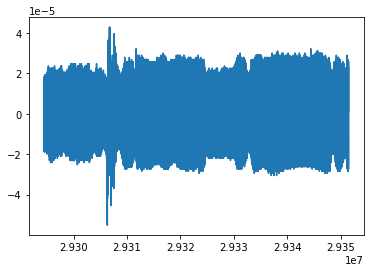

In [24]:
print(sz_list[5][0])
print(len(sz_list[5][2]))
exa = sz_list[5][2]
exa['CH-1'].plot(x = "timestampMS")

Weird spikes still in the original data.

20190521155643_p4Nat2.sdeeg_converted_.easy_filtered.edf
32061994


<AxesSubplot:>

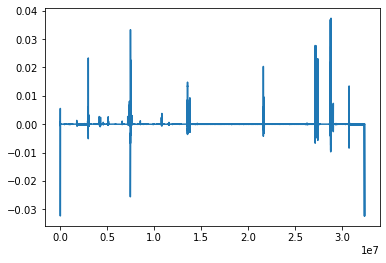

In [25]:
print(df_list[0][1])
exa2 = df_list[0][0]
print(len(exa2))
exa2['CH-1'].plot()

# Balancing dataset 

In [26]:
non_sz_p4_nat2 = df_list[0][0]
print(len(non_sz_p4_nat2))
non_sz_p4_nat2.head()

32061994


,timestampMS,CH-1,CH-2,CH-3,CH-4,CH-5,CH-6,CH-7,CH-8,x,y,z
0,1.558447e+12,0.000017,0.000058,0.001171,0.001181,-0.000045,-0.000051,-0.000065,0.000008,8.610537e-08,3.069114e-08,4.796582e-08
1,1.558447e+12,0.000011,0.000053,0.001170,0.001180,-0.000051,-0.000057,-0.000070,0.000003,8.610537e-08,3.069114e-08,4.796582e-08
2,1.558447e+12,0.000036,0.000079,0.001169,0.001180,-0.000026,-0.000032,-0.000045,0.000029,8.610537e-08,3.069114e-08,4.796582e-08
3,1.558447e+12,0.000038,0.000079,0.001168,0.001179,-0.000025,-0.000032,-0.000045,0.000029,8.610537e-08,3.069114e-08,4.796582e-08
4,1.558447e+12,0.000064,0.000105,0.001167,0.001178,0.000003,-0.000005,-0.000017,0.000056,8.610537e-08,3.069114e-08,4.796582e-08


In [27]:
sz_p4_nat2 = pd.concat([sz_list[0][2], sz_list[1][2], sz_list[2][2], sz_list[3][2], sz_list[4][2], sz_list[5][2]]) 
print(len(sz_p4_nat2))
sz_p4_nat2

338006


,timestampMS,CH-1,CH-2,CH-3,CH-4,CH-5,CH-6,CH-7,CH-8,x,y,z
19444500,1.558486e+12,0.000005,2.881900e-06,0.000011,0.000012,0.000011,0.000011,0.000011,0.000012,-1.594670e-07,3.111999e-07,-2.690678e-08
19444501,1.558486e+12,-0.000023,3.990707e-07,-0.000085,-0.000084,-0.000085,-0.000084,-0.000084,-0.000083,-1.594670e-07,3.111999e-07,-2.690678e-08
19444502,1.558486e+12,-0.000042,-2.083758e-06,-0.000151,-0.000150,-0.000152,-0.000150,-0.000150,-0.000150,-1.594670e-07,1.936214e-07,-5.685582e-08
19444503,1.558486e+12,-0.000038,-4.566587e-06,-0.000132,-0.000132,-0.000134,-0.000132,-0.000133,-0.000133,-1.594670e-07,1.936214e-07,-5.685582e-08
19444504,1.558486e+12,-0.000026,-7.049416e-06,-0.000092,-0.000092,-0.000093,-0.000092,-0.000092,-0.000092,-1.594670e-07,1.936214e-07,-5.685582e-08
...,...,...,...,...,...,...,...,...,...,...,...,...
29351496,1.558506e+12,0.000016,-3.325173e-06,0.000058,0.000058,0.000059,0.000060,0.000059,0.000060,-1.617910e-07,2.776061e-07,1.340693e-07
29351497,1.558506e+12,0.000026,-2.083758e-06,0.000089,0.000088,0.000090,0.000090,0.000089,0.000090,-1.617910e-07,2.776061e-07,1.340693e-07
29351498,1.558506e+12,0.000023,3.990707e-07,0.000077,0.000078,0.000080,0.000080,0.000080,0.000081,-1.617910e-07,2.776061e-07,1.340693e-07
29351499,1.558506e+12,0.000012,2.881900e-06,0.000035,0.000036,0.000036,0.000038,0.000036,0.000037,-1.617910e-07,2.776061e-07,1.340693e-07


difference in %

In [28]:
(len(sz_p4_nat2) / len(non_sz_p4_nat2)) * 100

1.0542263840483532

In [29]:
sz_p4_nat2.insert(1, "class", ["sz" for x in sz_p4_nat2.index])
sz_p4_nat2.head()

,timestampMS,class,CH-1,CH-2,CH-3,CH-4,CH-5,CH-6,CH-7,CH-8,x,y,z
19444500,1.558486e+12,sz,0.000005,2.881900e-06,0.000011,0.000012,0.000011,0.000011,0.000011,0.000012,-1.594670e-07,3.111999e-07,-2.690678e-08
19444501,1.558486e+12,sz,-0.000023,3.990707e-07,-0.000085,-0.000084,-0.000085,-0.000084,-0.000084,-0.000083,-1.594670e-07,3.111999e-07,-2.690678e-08
19444502,1.558486e+12,sz,-0.000042,-2.083758e-06,-0.000151,-0.000150,-0.000152,-0.000150,-0.000150,-0.000150,-1.594670e-07,1.936214e-07,-5.685582e-08
19444503,1.558486e+12,sz,-0.000038,-4.566587e-06,-0.000132,-0.000132,-0.000134,-0.000132,-0.000133,-0.000133,-1.594670e-07,1.936214e-07,-5.685582e-08
19444504,1.558486e+12,sz,-0.000026,-7.049416e-06,-0.000092,-0.000092,-0.000093,-0.000092,-0.000092,-0.000092,-1.594670e-07,1.936214e-07,-5.685582e-08


In [32]:
print(len(non_sz_p4_nat2) + len(sz_p4_nat2))

32400000


In [30]:
p4_nat2_df = pd.concat([non_sz_p4_nat2, sz_p4_nat2])
p4_nat2_df['class'].value_counts()

sz    338006
Name: class, dtype: int64

In [31]:
p4_nat2_df.shape

(32400000, 13)

In [33]:
p4_nat2_df.drop('x', inplace=True,  axis=1)
p4_nat2_df.drop('y', inplace=True,  axis=1)
p4_nat2_df.drop('z', inplace=True,  axis=1)

In [34]:
p4_nat2_df.head()

,timestampMS,CH-1,CH-2,CH-3,CH-4,CH-5,CH-6,CH-7,CH-8,class
0,1.558447e+12,0.000017,0.000058,0.001171,0.001181,-0.000045,-0.000051,-0.000065,0.000008,NaN
1,1.558447e+12,0.000011,0.000053,0.001170,0.001180,-0.000051,-0.000057,-0.000070,0.000003,NaN
2,1.558447e+12,0.000036,0.000079,0.001169,0.001180,-0.000026,-0.000032,-0.000045,0.000029,NaN
3,1.558447e+12,0.000038,0.000079,0.001168,0.001179,-0.000025,-0.000032,-0.000045,0.000029,NaN
4,1.558447e+12,0.000064,0.000105,0.001167,0.001178,0.000003,-0.000005,-0.000017,0.000056,NaN


In [36]:
p4_nat2_df['class'] = p4_nat2_df['class'].replace(np.nan, 'non-sz')
p4_nat2_df.head()

,timestampMS,CH-1,CH-2,CH-3,CH-4,CH-5,CH-6,CH-7,CH-8,class
0,1.558447e+12,0.000017,0.000058,0.001171,0.001181,-0.000045,-0.000051,-0.000065,0.000008,non-sz
1,1.558447e+12,0.000011,0.000053,0.001170,0.001180,-0.000051,-0.000057,-0.000070,0.000003,non-sz
2,1.558447e+12,0.000036,0.000079,0.001169,0.001180,-0.000026,-0.000032,-0.000045,0.000029,non-sz
3,1.558447e+12,0.000038,0.000079,0.001168,0.001179,-0.000025,-0.000032,-0.000045,0.000029,non-sz
4,1.558447e+12,0.000064,0.000105,0.001167,0.001178,0.000003,-0.000005,-0.000017,0.000056,non-sz


In [37]:
p4_nat2_df['class'].value_counts()

non-sz    32061994
sz          338006
Name: class, dtype: int64

# Create EEG's

In [38]:
def get_window(start_index, data, size = 4, overlap = 0, is_sezure = False, frequency = 500):
    if(is_sezure):
        overlap = 2
    else:
        overlap = overlap
    
    
    start = start_index * (size - overlap) * frequency
    end = start + (size * frequency)
    print("is_sezure: " + str(is_sezure) + " date: " + str(datetime.fromtimestamp((data['timestampMS'][start:start+1]/1000).tolist()[0])) + str(' lenthWindow: '+ str(len(data['CH-1'][start:end].tolist()))) + ' start: ' + str(start) + " end: " + str(end) )

    return [data['CH-1'][start:end].tolist(), datetime.fromtimestamp((data['timestampMS'][start:start+1]/1000).tolist()[0])]

In [40]:
sz = p4_nat2_df.loc[p4_nat2_df['class'] == 'sz']
nsz = p4_nat2_df.loc[p4_nat2_df['class'] == 'non-sz']

In [44]:
nosz_len = int(len(nsz) / (4*500))

In [45]:
sz_len = int(len(sz) / (2*500))

In [46]:
nsz_win = [get_window(start_index=i, data=nsz) for i in range(nosz_len)]
sz_win = [get_window(start_index=i, data=nsz, is_sezure=True) for i in range(sz_len)]

is_sezure: False date: 2019-05-21 15:56:43 lenthWindow: 2000 start: 0 end: 2000
is_sezure: False date: 2019-05-21 15:56:47 lenthWindow: 2000 start: 2000 end: 4000
is_sezure: False date: 2019-05-21 15:56:51 lenthWindow: 2000 start: 4000 end: 6000
is_sezure: False date: 2019-05-21 15:56:55 lenthWindow: 2000 start: 6000 end: 8000
is_sezure: False date: 2019-05-21 15:56:59 lenthWindow: 2000 start: 8000 end: 10000
is_sezure: False date: 2019-05-21 15:57:03 lenthWindow: 2000 start: 10000 end: 12000
is_sezure: False date: 2019-05-21 15:57:07 lenthWindow: 2000 start: 12000 end: 14000
is_sezure: False date: 2019-05-21 15:57:11 lenthWindow: 2000 start: 14000 end: 16000
is_sezure: False date: 2019-05-21 15:57:15 lenthWindow: 2000 start: 16000 end: 18000
is_sezure: False date: 2019-05-21 15:57:19 lenthWindow: 2000 start: 18000 end: 20000
is_sezure: False date: 2019-05-21 15:57:23 lenthWindow: 2000 start: 20000 end: 22000
is_sezure: False date: 2019-05-21 15:57:27 lenthWindow: 2000 start: 22000 end

In [47]:
non_sz_index_length = int(len(nsz_win))
sz_index_length = int(len(sz_win))
print(non_sz_index_length)
print(sz_index_length)
random_indexes_undersambler = random.sample(range(0,non_sz_index_length), sz_index_length)
random_indexes_undersambler

16030
338


[12768,
 9686,
 11845,
 7939,
 9972,
 4376,
 14192,
 2916,
 2937,
 14057,
 11900,
 12080,
 587,
 8785,
 1851,
 13262,
 7180,
 11493,
 3567,
 7594,
 15914,
 2528,
 9306,
 2529,
 1500,
 15679,
 8231,
 8561,
 8748,
 11590,
 4798,
 11776,
 12452,
 2596,
 4764,
 13291,
 193,
 9844,
 10389,
 7550,
 9784,
 2935,
 5842,
 6607,
 1957,
 8091,
 10937,
 7029,
 9120,
 6495,
 13046,
 2497,
 10192,
 4361,
 15009,
 8730,
 1269,
 10970,
 207,
 414,
 14640,
 14058,
 7582,
 14491,
 6581,
 12539,
 4059,
 3883,
 15362,
 14959,
 9492,
 9475,
 9193,
 3757,
 408,
 9480,
 1513,
 12111,
 721,
 3648,
 7567,
 13442,
 1441,
 1166,
 11670,
 7774,
 8896,
 1078,
 3352,
 4184,
 11620,
 15467,
 4778,
 7237,
 7038,
 11658,
 6528,
 206,
 783,
 10930,
 13512,
 14848,
 2354,
 9522,
 1700,
 3585,
 4337,
 13403,
 13327,
 8227,
 615,
 6252,
 14137,
 4641,
 8169,
 2060,
 15570,
 6949,
 13304,
 13531,
 7584,
 9854,
 3443,
 932,
 710,
 11903,
 6440,
 11127,
 7172,
 14450,
 5990,
 1856,
 11703,
 6837,
 13069,
 336,
 8624,
 6199,


In [48]:
list_keeper = []
for i in random_indexes_undersambler:
    window_of_choice = nsz_win[i]
    list_keeper.append(window_of_choice)
print(len(list_keeper))

338


In [49]:
nsz_win = list_keeper
for x in range(5):
    print(nsz_win[x][1])

2019-05-22 06:13:32.006000
2019-05-22 02:42:27
2019-05-22 05:10:12.004000
2019-05-22 00:45:59
2019-05-22 03:03:27.002000


In [50]:
print(type(nsz_win[x][0]))
print(type(nsz_win[x][0]))

<class 'list'>
<class 'list'>


In [51]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

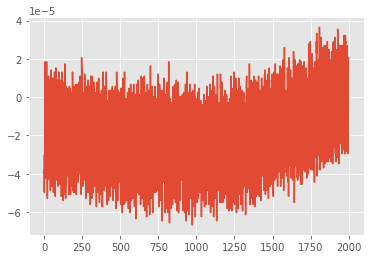

In [52]:
w = np.array(sz_win[2][0])
plt.plot(w)

<Figure size 216x288 with 0 Axes>

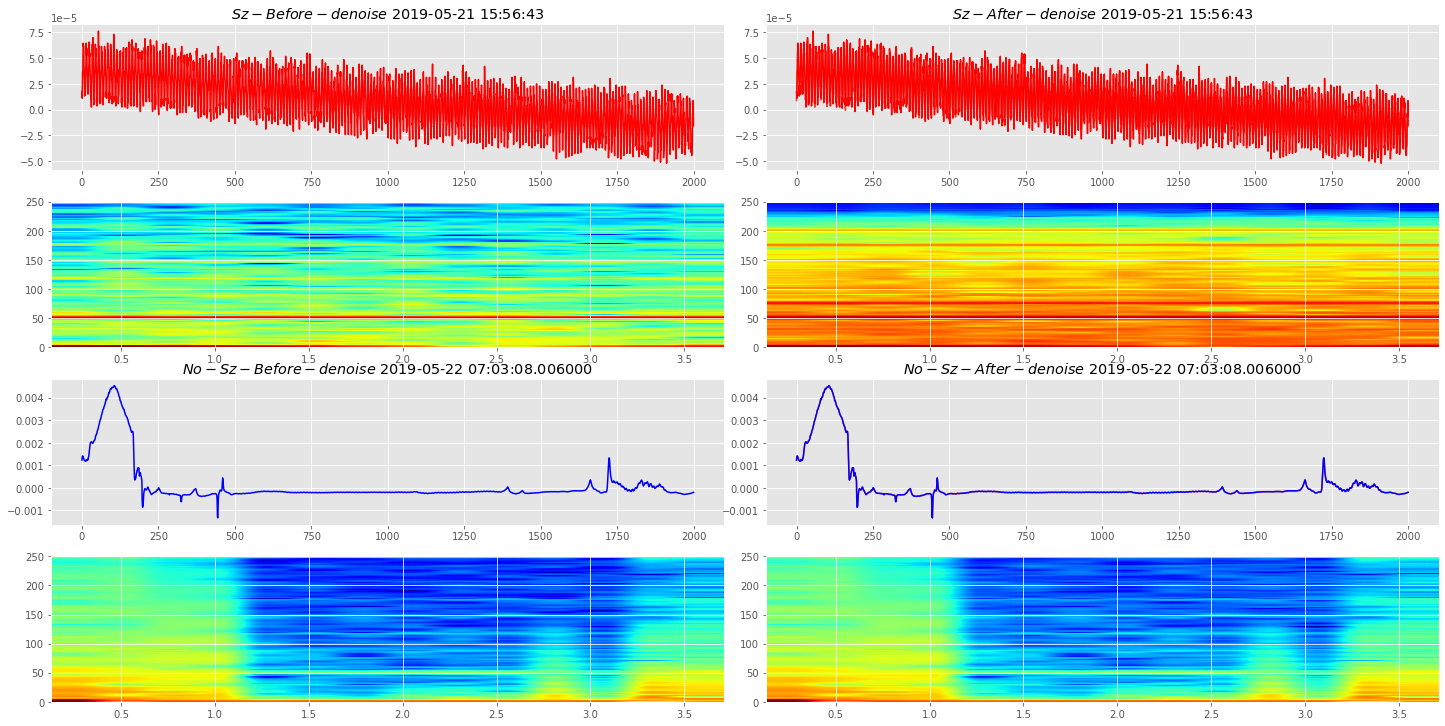

In [53]:
plt.figure(figsize=(3,4))
fig, axs = plt.subplots(4,2, figsize=(20,10))
plt.tight_layout()

for win in sz_win[0:1]:
    series, date_of_observation = win
    series = np.array(series)
    denoised_series = denoise_wavelet(series, method='BayesShrink',wavelet='db6', mode='soft',rescale_sigma=True, wavelet_levels=3)
    axs[0,0].set_title(f'$Sz-Before-denoise$ {date_of_observation}')
    axs[0,0].plot(series, color='red')
    axs[0,1].set_title(f'$Sz-After-denoise$ {date_of_observation}')
    axs[0,1].plot(denoised_series)
    axs[0,1].plot(series, color='red')
    pxx, freqs, bins, img = axs[1, 0].specgram(series,Fs=500,cmap='jet')
    pxx, freqs, bins, img = axs[1, 1].specgram(denoised_series,Fs=500,cmap='jet')

for win in nsz_win[100:101]:
    series, date_of_observation = win
    series = np.array(series)
    denoised_series = denoise_wavelet(series, method='BayesShrink',wavelet='db6', mode='soft',rescale_sigma=True, wavelet_levels=3)
    axs[2,0].set_title(f'$No-Sz-Before-denoise$ {date_of_observation}')
    axs[2,0].plot(series, color='blue')
    axs[2,1].set_title(f'$No-Sz-After-denoise$ {date_of_observation}')
    axs[2,1].plot(denoised_series)
    axs[2,1].plot(series, color='blue')
    pxx, freqs, bins, img = axs[3, 0].specgram(series,Fs=500,cmap='jet')
    pxx, freqs, bins, img = axs[3, 1].specgram(denoised_series,Fs=500,cmap='jet')



In [58]:
safe_window_path = "Dataset/windows/p4_nat2/"
sz_path = "sz/"
non_sz_path = "non-sz/"

In [59]:
def spec_transform_save_to_folder(index, win, is_seizure=False):
    plt.figure(figsize=(7,7))
    series, date_of_observation = win
    series = np.array(series)
    denoised_series = denoise_wavelet(series, method='BayesShrink',wavelet='db6', mode='soft',rescale_sigma=True, wavelet_levels=3)
    pxx, freqs, bins, img = plt.specgram(denoised_series,Fs=500,cmap='jet')
    if(is_seizure):
        plt.savefig(f'{safe_window_path}{sz_path}sz_{index}_{date_of_observation}.png')
    else:
        plt.savefig(f'{safe_window_path}{non_sz_path}nsz_{index}_{date_of_observation}.png')
    plt.close()

#Write to folders

for index, win in enumerate(sz_win):
    spec_transform_save_to_folder(index, win, is_seizure=True)

for index, win in enumerate(nsz_win):
    spec_transform_save_to_folder(index, win)


# Load png's and convert to np arrays with labels

In [60]:
event_time_path = "p4_nat2"
path_to_specplots = "Dataset/Windows/" + event_time_path

In [61]:
labels = [item for item in os.listdir(path_to_specplots)]
labels = np.array(labels)
labels = labels[1:]
print(labels.shape)
labels

(2,)


array(['non-sz', 'sz'], dtype='<U9')

In [62]:
data_generator = ImageDataGenerator(rescale = 1./255, validation_split=0.3)

# Train, Test splits

In [63]:
spec_img_target_size_inception = (299, 299)
spec_img_target_size_inception_resnet = (224, 224)
spec_img_target_size_resnet = (299, 299)

In [64]:
train_data = data_generator.flow_from_directory(path_to_specplots, target_size=spec_img_target_size_inception, color_mode='rgb', batch_size=32, classes = list(labels), subset='training')

valida_data = data_generator.flow_from_directory(path_to_specplots, target_size=spec_img_target_size_inception, color_mode='rgb', batch_size=32, classes = list(labels), subset='validation')

Found 474 images belonging to 2 classes.
Found 202 images belonging to 2 classes.


## notice! we have the right img shape for the inception network as in the paper

In [65]:
train_data.image_shape

(299, 299, 3)

In [66]:
def show_batch(image, label):
  plt.figure(figsize=(10,10))
  for n in range(15):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image[n])
      plt.title(labels[label[n].argmax()])
      plt.axis('off')

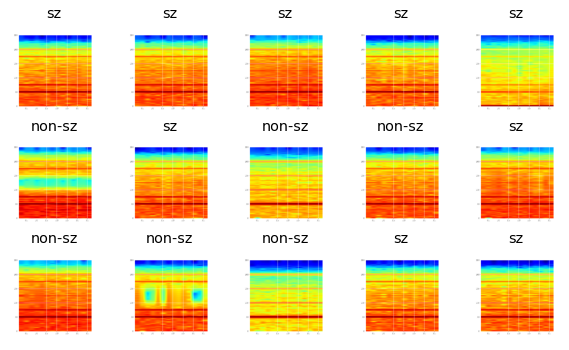

In [67]:
image, label = next(train_data)
show_batch(image, label)

## The paper loads the pretrained weights and doesn't freeze them

" Inception-v3
has input images with a size of 299 × 299 × 3 and outputs
2,048-dimensional feature vectors" <br/>
" (2) Loading
pre-trained weights, and updating the parameters of the whole
network during training.
When the current datasets differ greatly from the datasets
used in pre-trained weight training, the second approach above
is usually adopted"

In [68]:
from tensorflow.keras.applications import InceptionV3

base_inceptionV3 = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape = ((299, 299, 3))
)

for layer in base_inceptionV3.layers:
    layer.trainable = True


"Two fully connected layers with 1,024 and 512
neurons are added to reduce the dimensions, and a dropout
layer (0.5) is set behind each fully connected layer to prevent
over-fitting. The softmax of the output layer is expressed as:" <br/>
"For each image, the feature vectors extracted from three
network features are concatenated into a 5,632-dimensional
feature vector." 

In [69]:
single_inc_model = Sequential()

single_inc_model.add(base_inceptionV3)
single_inc_model.add(layers.Dense(1024, activation='relu'))
single_inc_model.add(layers.Dropout(0.5))
single_inc_model.add(layers.Flatten())
single_inc_model.add(layers.Dense(512, activation='relu'))
single_inc_model.add(layers.Dropout(0.5))
single_inc_model.add(layers.Dense(2, activation='softmax'))


"An online hard example mining (OHEM) (29) loss function is
used to replace the commonly used cross-entropy loss function;
its expression is as Equation (5). In OHEM, the loss of a batch
sample is sorted in descending order, and the largest k (topk
)
values are averaged as the final loss. "

In [ ]:
# CREATE OHEM LOSS se: https://heartbeat.comet.ml/how-to-create-a-custom-loss-function-in-keras-637bd312e9ab og https://github.com/GXYM/OHEM-loss/blob/master/Ohem.py

In [70]:
single_inc_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [71]:
single_inc_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
dense (Dense)                (None, 8, 8, 1024)        2098176   
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 1024)        0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               33554944  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1

In [73]:
class TestCallback(tensorflow.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x = self.test_data
        loss, acc = self.model.evaluate(x, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

In [75]:
history = single_inc_model.fit(
    train_data,
    epochs=10,
    steps_per_epoch = train_data.samples//32, 
    validation_data=valida_data, 
    validation_steps = valida_data.samples//32,
    callbacks=[TestCallback((valida_data))]
)

Epoch 1/10
14/14 [==============================] - 34s 2s/step - loss: 0.4110 - accuracy: 0.8393 - val_loss: 28.4971 - val_accuracy: 0.4896

Testing loss: 28.064552307128906, acc: 0.5

Epoch 2/10
14/14 [==============================] - 32s 2s/step - loss: 0.2383 - accuracy: 0.9276 - val_loss: 20.3493 - val_accuracy: 0.4948

Testing loss: 20.044116973876953, acc: 0.5

Epoch 3/10
14/14 [==============================] - 31s 2s/step - loss: 0.1873 - accuracy: 0.9412 - val_loss: 36.5299 - val_accuracy: 0.5000

Testing loss: 36.32017135620117, acc: 0.5

Epoch 4/10
14/14 [==============================] - 32s 2s/step - loss: 0.1117 - accuracy: 0.9615 - val_loss: 64.1979 - val_accuracy: 0.5156

Testing loss: 65.5732192993164, acc: 0.5

Epoch 5/10
14/14 [==============================] - 32s 2s/step - loss: 0.1108 - accuracy: 0.9706 - val_loss: 18.8070 - val_accuracy: 0.5052

Testing loss: 18.143980026245117, acc: 0.5049504637718201

Epoch 6/10
14/14 [==============================] - 32s 2s

<Figure size 216x288 with 0 Axes>

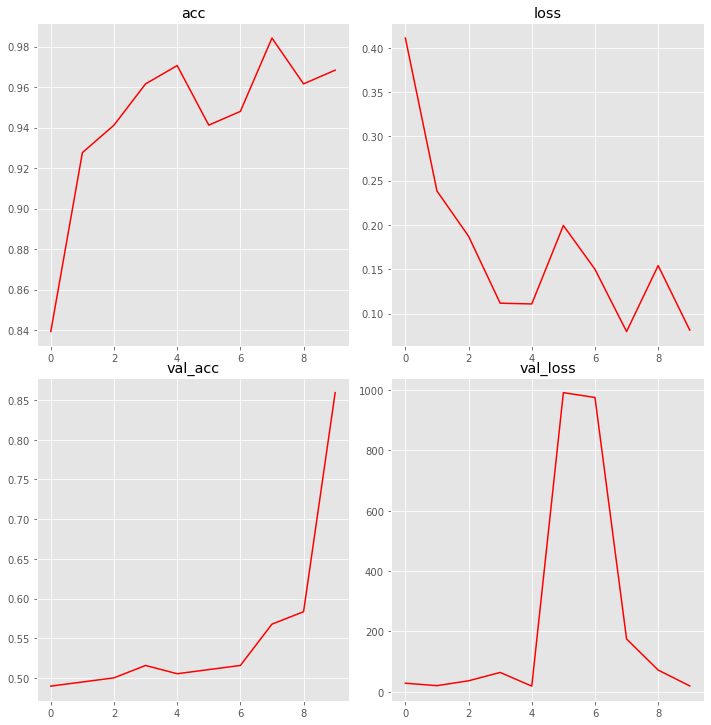

In [76]:
plt.figure(figsize=(3,4))
fig, axs = plt.subplots(2,2, figsize=(10,10))
plt.tight_layout()
axs[0,0].set_title('acc')
axs[0,0].plot(history.history['accuracy'], color='red')
axs[0,1].set_title('loss')
axs[0,1].plot(history.history['loss'], color='red')
axs[1,0].set_title('val_acc')
axs[1,0].plot(history.history['val_accuracy'], color='red')
axs[1,1].set_title('val_loss')
axs[1,1].plot(history.history['val_loss'], color='red')